In [1]:
class Tax:
    """
    Danish tax calculations (2025)
    Source: https://skat.dk/en-us/help/tax-rates
    """
    LABOR_MARKET_TAX_RATE: float = 0.08
    KOMMUNE_TAX_RATE: float = 0.2457
    BOTTOM_TAX_RATE: float = 0.1201
    TOP_TAX_RATE: float = 0.15
    TOP_TAX_BRACKET_LIMIT: int = 611800
    INCOME_TAX_CEILING: float = 0.5207
    PERSONAL_TAX_ALLOWANCE: int = 51600
    EMPLOYMENT_DEDUCTION_RATE: float = 0.123
    EMPLOYMENT_DEDUCTION_CEILING: int = 55600
    JOB_ALLOWANCE_RATE: float = 0.045
    JOB_ALLOWANCE_THRESHOLD: int = 224500
    JOB_ALLOWANCE_CEILING: float = 2900
    DEDUCTION_TAX_RATE: float = 0.37 # This is the tax rate for deductions

    CAPITAL_GAIN_TAX_RATE: float = 0.27
    CAPITAL_GAIN_GRADUATED_LIMIT: int = 67500
    CAPITAL_GAIN_TAX_GRADUATED_RATE: float = 0.42
    CAPTIAL_GAIN_TAX_CEILING: float = 0.42
    TOP_CAPITAL_INCOME_DEDUCTION_ALLOWANCE: int = 52400

    AKTIESPAREKONTO_LIMIT: int = 166200
    AKTIESPAREKONTO_TAX_RATE: float = 0.17

    @classmethod
    def cal_monthly_tax_deduction_amount(cls, anual_salary: float) -> float:
        """
        Calculate the monthly tax deduction amount based on the personal tax allowance.

        Args:
            anual_salary (float): The annual salary of the individual.
        
        Returns:
            float: The monthly tax deduction amount.
        """
        # Employment deduction
        emp_deduct = anual_salary * cls.EMPLOYMENT_DEDUCTION_RATE
        emp_deduct = min(emp_deduct, cls.EMPLOYMENT_DEDUCTION_CEILING)

        # Job allowance
        job_allowance = max(0, anual_salary - cls.JOB_ALLOWANCE_THRESHOLD) * cls.JOB_ALLOWANCE_RATE
        job_allowance = min(job_allowance, cls.JOB_ALLOWANCE_CEILING)

        # Kommune tax deduction
        total_kommune_deduct = (emp_deduct + job_allowance + cls.PERSONAL_TAX_ALLOWANCE) * cls.KOMMUNE_TAX_RATE

        # Bottom tax deduction
        total_bottom_tax_deduct = cls.PERSONAL_TAX_ALLOWANCE * cls.BOTTOM_TAX_RATE

        # Total tax deduction
        total_tax_deduct = total_kommune_deduct + total_bottom_tax_deduct

        # Convert to equivalent taxable income amount
        total_deduct_amount = total_tax_deduct / cls.DEDUCTION_TAX_RATE

        # Monthly tax deduction
        monthly_tax_deduct = total_deduct_amount / 12

        return round(monthly_tax_deduct)
    
    @classmethod
    def cal_monthly_tax_amount(cls, monthly_salary: float) -> float:
        """
        Calculate the monthly tax amount based on the monthly salary.

        Args:
            monthly_salary (float): The monthly salary of the individual.
        
        Returns:
            float: The monthly tax amount.
        """
        # Monthly labor market tax
        labor_market_tax = monthly_salary * cls.LABOR_MARKET_TAX_RATE
        salary_after_labor_tax = monthly_salary - labor_market_tax

        # Tax deduction amount
        monthly_tax_deduct = cls.cal_monthly_tax_deduction_amount(monthly_salary * 12)
        taxabile_income = salary_after_labor_tax - monthly_tax_deduct

        # Tax
        if taxabile_income <= 0:
            return 0.0
        
        tax_rate = cls.DEDUCTION_TAX_RATE
        tax_rate = tax_rate if tax_rate < cls.INCOME_TAX_CEILING else cls.INCOME_TAX_CEILING

        monthly_tax = taxabile_income * tax_rate
        return round(monthly_tax, 2)
    
    @classmethod
    def cal_monthly_salary_after_tax(cls, monthly_salary: float) -> float:
        """
        Calculate the monthly salary after tax.

        Args:
            monthly_salary (float): The monthly salary of the individual.
        
        Returns:
            float: The monthly salary after tax.
        """
        # Monthly labor market tax
        labor_market_tax = monthly_salary * cls.LABOR_MARKET_TAX_RATE
        salary_after_labor_tax = monthly_salary - labor_market_tax
        monthly_tax = cls.cal_monthly_tax_amount(monthly_salary)
        return round(salary_after_labor_tax - monthly_tax, 2)



In [2]:
anual_salary = 588000
Tax.cal_monthly_tax_deduction_amount(anual_salary)

7488

In [3]:
monthly_salary = anual_salary / 12
Tax.cal_monthly_salary_after_tax(monthly_salary)

31170.96

In [4]:
class PersonalFinance:
      
    """
    Personal finance calculations for investment and tax.
    """
    def __init__(self, annual_salary: float, annual_salary_raise: float = 0.03):
        """
        Initialize the personal finance calculator.
        """
        self.annual_salary = annual_salary
        self.annual_salary_raise = annual_salary_raise

    def raise_salary(self):
        """
        Raise the annual salary by the specified percentage.
        """
        self.annual_salary *= (1 + self.annual_salary_raise)

    def get_monthly_net_salary(self) -> float:
        """
        Calculate the monthly net salary after tax.

        Returns:
            float: The monthly net salary.
        """
        monthly_salary = self.annual_salary / 12
        return Tax.cal_monthly_salary_after_tax(monthly_salary)


class InvestmentSimulator:
    """
    Investment simulator for calculating future investment value.
    """

    def __init__(self, 
                pf: PersonalFinance, 
                init_investment: float, 
                invest_percent: float, 
                annual_return: float, 
                months: int,):
        """
        Initialize the investment simulator.

        Args:
            pf (PersonalFinance): The personal finance calculator.
            init_investment (float): Initial investment amount.
            invest_percent (float): Percentage of monthly salary to invest.
            annual_return (float): Expected annual return rate.
            months (int): Number of months to simulate.
        """

        self.pf = pf
        self.init_investment = init_investment
        self.invest_percent = invest_percent
        self.annual_return = annual_return
        self.monthly_return = (1 + annual_return) ** (1/12) - 1
        self.months = months

        self.reults = []

    def simulate(self):
        """
        Simulate the investment growth over the specified months.
        """
        current_investment = self.init_investment
        for month in range(self.months):
            monthly_investment = self.pf.get_monthly_net_salary() * self.invest_percent
            current_investment *= (1 + self.monthly_return)
            current_investment += monthly_investment
            self.reults.append(round(current_investment, 2))

            if month % 12 == 0 and month > 0:
                # Raise salary every year
                self.pf.raise_salary()
        
        return self.reults
    
    def print_sim_report(self):
        """
        Print the investment simulation report.
        """
        print(f"Initial Investment: {self.init_investment}")
        print(f"Monthly Investment Percentage: {self.invest_percent * 100}%")
        print(f"Monthly Investment Amount: {self.pf.get_monthly_net_salary() * self.invest_percent}")
        print(f"Expected Annual Return Rate: {self.annual_return * 100}%")
        print(f"Expected Monthly Return Rate: {self.monthly_return * 100}%")
        print(f"Total Months: {self.months}")
        print("Investment Growth Over Time:")
        for month, value in enumerate(self.reults, start=1):
            print(f"Month {month}: {value}")

    

In [5]:
pf = PersonalFinance(annual_salary=588000, annual_salary_raise=0.03)
investment_simulator = InvestmentSimulator(
    pf=pf, 
    init_investment=180000, 
    invest_percent=0.5, 
    annual_return=0.2, 
    months=120
)

investment_simulator.simulate()
investment_simulator.print_sim_report()

Initial Investment: 180000
Monthly Investment Percentage: 50.0%
Monthly Investment Amount: 19913.325
Expected Annual Return Rate: 20.0%
Expected Monthly Return Rate: 1.5309470499731193%
Total Months: 120
Investment Growth Over Time:
Month 1: 198341.18
Month 2: 216963.16
Month 3: 235870.23
Month 4: 255066.76
Month 5: 274557.18
Month 6: 294345.98
Month 7: 314437.75
Month 8: 334837.1
Month 9: 355548.76
Month 10: 376577.5
Month 11: 397928.19
Month 12: 419605.74
Month 13: 441615.16
Month 14: 464387.54
Month 15: 487508.55
Month 16: 510983.53
Month 17: 534817.9
Month 18: 559017.17
Month 19: 583586.91
Month 20: 608532.8
Month 21: 633860.6
Month 22: 659576.16
Month 23: 685685.4
Month 24: 712194.37
Month 25: 739109.17
Month 26: 766874.81
Month 27: 795065.53
Month 28: 823687.83
Month 29: 852748.33
Month 30: 882253.72
Month 31: 912210.83
Month 32: 942626.56
Month 33: 973507.95
Month 34: 1004862.11
Month 35: 1036696.29
Month 36: 1069017.83
Month 37: 1101834.19
Month 38: 1135604.91
Month 39: 1169892

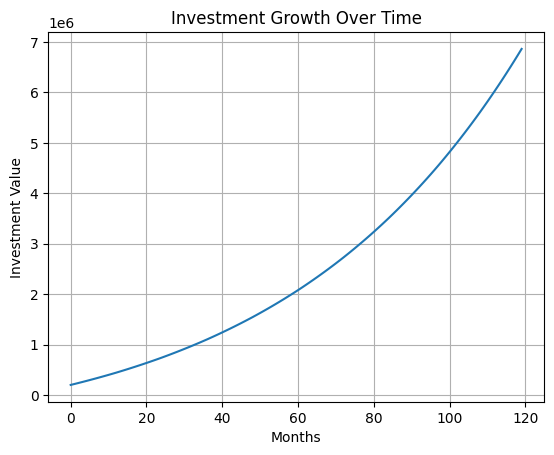

In [6]:
from matplotlib import pyplot as plt

plt.plot(investment_simulator.reults)
plt.xlabel('Months')
plt.ylabel('Investment Value')
plt.title('Investment Growth Over Time')
plt.grid(True)
plt.show()